In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Preparation


In [ ]:
import glob
import random
import re
import pickle
from collections import Counter
import numpy as np
import pandas as pd
import csv
import random

In [ ]:
RAW_DATA_FILE = '/content/drive/MyDrive/6220 Project/SpamDatasets/processed_data/fully_combined_data.csv'

In [ ]:
TRAIN_TEST_DIR = '/content/drive/MyDrive/6220 Project/Neural Network/train_test_data'

In [ ]:
# VISUALIZE DATA
raw_data_df = pd.read_csv(RAW_DATA_FILE, header=None)
raw_data_df.columns = ['text', 'spam']
raw_data_df.head()

,text,spam
0,recommend view accurately someone dream change...,1
1,dec prod panther pipeline demand charge please...,0
2,refill notification ref voyage scalp overseer ...,1
3,reference ohi hello send email days ago want c...,1
4,important online bank alert dear value tcf ban...,1


In [ ]:
# step 1a
def create_bag_of_words_from_text(list_of_texts):
    '''
    Input:
      filePaths: Array. A list of email texts
    Returns:
      bagOfWords: Array. All tokens in texts
    '''
    bag_of_words = []
    for raw_text in list_of_texts:
      tokens = raw_text.split() 
      for token in tokens:
        bag_of_words.append(token)

    return bag_of_words

In [ ]:
# step 1b
def get_feature_matrix_from_texts(list_of_texts, feature_dict):
        '''
        create feature/x matrix from multiple texts
        rows = texts, cols = features
        '''
        feature_matrix = np.zeros(shape=(len(list_of_texts),
                                          len(feature_dict)),
                                   dtype=float)
        
        for i, raw_text in enumerate(list_of_texts):
            tokens = raw_text.split()
            file_uni_dist = Counter(tokens)
            for key,value in file_uni_dist.items():
                if key in feature_dict:
                    feature_matrix[i, feature_dict[key]] = value

        return feature_matrix

In [ ]:
# step 1c
def regularize_vectors(feature_matrix):
    '''
    Input:
      feature_matrix: matrix, where docs are rows and features are columns
    Returns:
      feature_matrix: matrix, updated by dividing each feature value by the total
      number of features for a given document
    '''
    for doc in range(feature_matrix.shape[0]):
        totalWords = np.sum(feature_matrix[doc,:],axis=0)
        feature_matrix[doc,:] = np.multiply(feature_matrix[doc,:],(1/(totalWords + 1e-5)))
    return feature_matrix

In [ ]:
# step 1
def create_train_test_data(file_path, percent_test, cutoff):
    ''' 
    Input:
      file_path: String. dir of fully combined csv file
      percentTest: Float. percentage of all data to be assigned to testset
    Returns:
      trainX: Array. Absolute paths to training emails
      testX: Array. Absolute paths to testing emails
      trainY: Array. Ground truth values spam or not
      testY: Array. Ground truth values spam or not
    '''
    # read csv of data
    file = open(file_path)
    csv.field_size_limit(100000000)
    csvreader = csv.reader(file)
    rows = []
    for i, row in enumerate(csvreader):
        rows.append([i] + row)
    file.close()

    # shuffle rows
    random.shuffle(rows)

    # create train-test split
    num_test = int(percent_test * len(rows))
    test_data = rows[:num_test]
    print('Num test samples: ', len(test_data))
    train_data = rows[num_test:]
    print('Num train samples: ', len(train_data))

    # separate text and labels for further processing
    testX = []
    testY = []
    test_ids = []
    for row in test_data:
        id, text, label = row
        test_ids.append(id)
        testX.append(text)
        testY.append(label)

    trainX = []
    trainY = []
    train_ids = []
    for row in train_data:
        id, text, label = row
        train_ids.append(id)
        trainX.append(text)
        trainY.append(label)

    # create feature dictionary of n-grams from training data
    bag_of_words = create_bag_of_words_from_text(trainX)

    # throw out low freq words
    freqDist = Counter(bag_of_words)
    new_bag_of_words=[]
    for word,freq in freqDist.items():
        if freq > cutoff:
            new_bag_of_words.append(word)

    pickle.dump(new_bag_of_words, open(f'{TRAIN_TEST_DIR}/train_bag_of_words.p', 'wb'))
    train_features = set(new_bag_of_words)
    feature_dict = {feature:i for i,feature in enumerate(train_features)}

    # make feature matrices
    trainX = get_feature_matrix_from_texts(trainX,feature_dict)
    testX = get_feature_matrix_from_texts(testX,feature_dict)

    # regularize length
    trainX = regularize_vectors(trainX)
    testX = regularize_vectors(testX)  

    # label formatting
    trainY = np.array([[0 if int(label) == 1 else 1, int(label)] for label in trainY])
    testY = np.array([[0 if int(label) == 1 else 1, int(label)] for label in testY])

    # return labels & data 
    return np.array(train_ids), np.array(test_ids), trainX, testX, trainY, testY

In [ ]:
train_ids, test_ids, trainX, testX, trainY, testY = create_train_test_data(RAW_DATA_FILE, 0.1, 50)

Num test samples:  3375
Num train samples:  30377


In [ ]:
print('Train_ids shape:', train_ids.shape)
print('TrainX shape: ', trainX.shape)
print('TrainY shape: ', trainY.shape)  

print('Test_ids shape:', test_ids.shape)
print('TestX shape: ', testX.shape)  
print('TestY shape: ', testY.shape)

Train_ids shape: (30377,)
TrainX shape:  (30377, 7215)
TrainY shape:  (30377, 2)
Test_ids shape: (3375,)
TestX shape:  (3375, 7215)
TestY shape:  (3375, 2)


In [ ]:
np.savetxt(f"{TRAIN_TEST_DIR}/train_ids.csv", train_ids, delimiter=",")
np.savetxt(f"{TRAIN_TEST_DIR}/trainX.csv", trainX, delimiter=",")
np.savetxt(f"{TRAIN_TEST_DIR}/trainY.csv", trainY, delimiter=",")
np.savetxt(f"{TRAIN_TEST_DIR}/test_ids.csv", test_ids, delimiter=",")
np.savetxt(f"{TRAIN_TEST_DIR}/testX.csv", testX, delimiter=",")
np.savetxt(f"{TRAIN_TEST_DIR}/testY.csv", testY, delimiter=",")

# Model Preparation

In [ ]:
# DATA_DIR = '/content/drive/MyDrive/6220 Project/Neural Network/train_test_data'
DATA_DIR = TRAIN_TEST_DIR

In [ ]:
# !pip uninstall tensorflow -y
!pip install tensorflow

In [ ]:
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import time
import pandas as pd

In [ ]:
# IGNORE IF YOU ALREADY HAVE trainX, trainY, testX, testY, etc. available
# GET SAVED TRAIN TEST DATA
def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype='float32')

def import_data():
    print("loading training data")
    # trainX = csv_to_numpy_array(f"{DATA_DIR}/trainX.csv", delimiter=",")
    trainX = pd.read_csv(f"{DATA_DIR}/trainX.csv").to_numpy()
    trainY = pd.read_csv(f"{DATA_DIR}/trainY.csv").to_numpy()
    train_ids = pd.read_csv(f"{DATA_DIR}/train_ids.csv").to_numpy()
    testX = pd.read_csv(f"{DATA_DIR}/testX.csv").to_numpy()
    testY = pd.read_csv(f"{DATA_DIR}/testY.csv").to_numpy()
    test_ids = pd.read_csv(f"{DATA_DIR}/test_ids.csv").to_numpy()

    return trainX,trainY,testX,testY,train_ids,test_ids

trainX,trainY,testX,testY,train_ids,test_ids = import_data()

loading training data


In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(30377, 7215)
(30377, 2)
(3375, 7215)
(3375, 2)


## Original Neural Network Model

In [ ]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [ ]:
tf.compat.v1.enable_eager_execution() 

In [ ]:
num_hidden_nodes1 = 2000
num_hidden_nodes2 = 1000
num_hidden_nodes3 = 256
keep_prob = 0.5
# numFeatures = the number of words extracted from each email
numFeatures = trainX.shape[1]
# numLabels = number of classes we are predicting (here just 2: Spam or Ham)
numLabels = trainY.shape[1]

graph = tf.Graph()
with graph.as_default():

  # Input data.
  
  tf_train_dataset = tf.constant(trainX, dtype=tf.float32)
  tf_train_labels = tf.constant(trainY, dtype=tf.float32)
  tf_test_dataset = tf.constant(testX, dtype=tf.float32)

  # Single mail input. 
  # tf_mail = tf.placeholder(tf.float32, shape=(1, numFeatures))
  tf_mail = tf.Variable(tf.zeros(shape=[1, numFeatures]), dtype=tf.float32)

  # Variables.
  weights1 = tf.Variable(tf.random.truncated_normal([numFeatures, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (numFeatures))),name="v1")
         
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]),name="v2")
  weights2 = tf.Variable(
    tf.random.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)),name="v3")
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]),name="v4")
  weights3 = tf.Variable(
       tf.random.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)),name="v5")
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]),name="v6")
  weights4 = tf.Variable(
    tf.random.truncated_normal([num_hidden_nodes3, numLabels], stddev=np.sqrt(2.0 / num_hidden_nodes3)),name="v7")
  biases4 = tf.Variable(tf.zeros([numLabels]),name="v8")
  
  # Add ops to save and restore all the variables.
  # saver = tf.train.Saver()
  saver = tf.compat.v1.train.Saver()
    
  # Training computation.
  layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(layer1_train, keep_prob)
  layer2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
  drop2 = tf.nn.dropout(layer2_train, keep_prob)
  layer3_train = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
  drop3 = tf.nn.dropout(layer3_train, keep_prob)
  logits = tf.matmul(drop3, weights4) + biases4
  loss = tf.reduce_mean(
     tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
  # Optimizer.

  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.1, 
                                              beta1=0.9, beta2=0.999, 
                                              epsilon=1e-08).minimize(loss)
  
  # Predictions for the training, test data, and single mail.
    
  train_prediction = tf.nn.sigmoid(logits)
  
  layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  layer2_test = tf.nn.relu(tf.matmul(layer1_test, weights2) + biases2)
  layer3_test = tf.nn.relu(tf.matmul(layer2_test, weights3) + biases3)
  test_prediction = tf.nn.sigmoid(tf.matmul(layer3_test, weights4) + biases4)
  
  layer1_mail = tf.nn.relu(tf.matmul(tf_mail, weights1) + biases1)
  layer2_mail = tf.nn.relu(tf.matmul(layer1_mail, weights2) + biases2)
  layer3_mail = tf.nn.relu(tf.matmul(layer2_mail, weights3) + biases3)
  prediction_mail = tf.nn.sigmoid(tf.matmul(layer3_mail, weights4) + biases4)

In [ ]:
num_steps = 151
start = time.time()

with tf.compat.v1.Session(graph=graph) as session:
  tf.compat.v1.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction])
    print(f'Train preds: {predictions.shape}')
    acc = accuracy(predictions,trainY)
    if (step % 10 == 0):
      print("Loss at step %d: %f" % (step, l))
      print("Accuracy: %.1f%%" % acc)
      
  test_preds = test_prediction.eval()
  print("Test accuracy: %.1f%%" % accuracy(test_preds, testY))
  print(f'Test preds: {predictions.shape}')

  # Save the variables to disk.
  save_path = saver.save(session, f"{DATA_DIR}/model.ckpt")
  print("Model saved in file: %s" % save_path)

end = time.time()
duration = end - start
print("time consumed in training: %f seconds" % duration)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Train preds: (30377, 2)
Loss at step 0: 0.693127
Accuracy: 50.8%
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Loss at step 10: 0.637312
Accuracy: 48.7%
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Loss at step 20: 0.358540
Accuracy: 81.0%
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Train preds: (30377, 2)
Loss at step 30: 0.214856
Accuracy: 87.9%
Tra

# Get Labeling for Data

In [ ]:
# Set this location to output directory for labeled data
LABELED_OUTPUT_DIR = '/content/drive/MyDrive/6220 Project/Neural Network'

In [ ]:
official_train_preds = np.argmax(predictions, 1) 
official_train_labels = np.argmax(trainY, 1)
print(official_train_preds.shape)
print(official_train_labels.shape)

In [ ]:
train_ids.shape

(30377,)

In [ ]:
official_train_data = pd.DataFrame(train_ids, columns=['index'])
official_train_data['pred'] = official_train_preds
official_train_data['gt_labels'] = official_train_labels
official_train_data.head()

,index,pred,gt_labels
0,13783,1,1
1,4632,1,1
2,4165,0,0
3,11844,0,0
4,982,1,1


In [ ]:
official_test_preds = np.argmax(test_preds, 1) 
official_test_labels = np.argmax(testY, 1)
print(official_test_preds.shape)
print(official_test_labels.shape)

(3375,)
(3375,)


In [ ]:
test_ids.shape

(3375,)

In [ ]:
official_test_data = pd.DataFrame(test_ids, columns=['index'])
official_test_data['pred'] = official_test_preds
official_test_data['gt_labels'] = official_test_labels
official_test_data.head()

,index,pred,gt_labels
0,32285,1,1
1,11468,0,0
2,9061,0,0
3,29735,0,0
4,12870,0,0


In [ ]:
fully_labeled_data = pd.concat([official_train_data, official_test_data])
len(fully_labeled_data)

33752

In [ ]:
# Check accuracy again
correctly_guessed = fully_labeled_data[fully_labeled_data['pred'] == fully_labeled_data['gt_labels']]
print(len(correctly_guessed))

31584


In [ ]:
accuracy = len(correctly_guessed) / len(fully_labeled_data) * 100.0
print(f'Overall Accuracy: {accuracy}')

Overall Accuracy: 93.57667693766295


In [ ]:
nn_labeled_data = fully_labeled_data[['index', 'pred']]
nn_labeled_data.to_csv(f'{LABELED_OUTPUT_DIR}/nn_labeled_data.csv', index=False)

In [ ]:
sorted_data = nn_labeled_data.sort_values(by=['index'])
sorted_data.to_csv(f'{LABELED_OUTPUT_DIR}/nn_labeled_data_sorted_by_index.csv', index=False)

# Data Statistics


In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
original_data = pd.read_csv(RAW_DATA_FILE, header=None, names=['text','spam'])
original_data.head(3)

,text,spam
0,recommend view accurately someone dream change...,1
1,dec prod panther pipeline demand charge please...,0
2,refill notification ref voyage scalp overseer ...,1


In [ ]:
spam_data = original_data[original_data['spam']==1]
ham_data = original_data[original_data['spam']==0]


In [ ]:
print(f'Num spam: {len(spam_data)}')
print(f'Num ham: {len(ham_data)}')

Num spam: 17609
Num ham: 16143


In [ ]:
def get_all_text(df, column_name):
  all_text = ''
  for val in df[column_name]:
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    all_text += " ".join(tokens)+" "
  return all_text


In [ ]:
all_spam_text = get_all_text(spam_data, 'text')
import nltk

data = all_spam_text.split(' ')
fdist_spam = nltk.FreqDist(data)
print(fdist_spam.most_common(50))


[('_', 43115), ('http', 25763), ('com', 13407), ('td', 13205), ('font', 12738), ('company', 12388), ('e', 10162), ('width', 10149), ('get', 9517), ('email', 9477), ('b', 8663), ('make', 7941), ('use', 7850), ('mail', 7687), ('br', 7500), ('please', 7425), ('information', 7276), ('time', 7265), ('p', 6914), ('price', 6903), ('one', 6868), ('tr', 6711), ('www', 6504), ('may', 6467), ('d', 6230), ('us', 6225), ('size', 6138), ('height', 6079), ('new', 6078), ('n', 5772), ('statements', 5766), ('list', 5615), ('go', 5514), ('report', 5283), ('look', 5278), ('src', 5277), ('money', 5185), ('free', 5152), ('img', 5092), ('need', 5087), ('de', 5085), ('send', 5057), ('business', 4908), ('stock', 4861), ('work', 4766), ('name', 4589), ('border', 4533), ('href', 4532), ('offer', 4448), ('face', 4425)]


In [ ]:
all_ham_text = get_all_text(ham_data, 'text')
data = all_ham_text.split(' ')
fdist_ham = nltk.FreqDist(data)
print(fdist_ham.most_common(50))


[('enron', 27977), ('font', 17296), ('d', 14103), ('http', 13041), ('say', 12225), ('company', 11819), ('td', 11049), ('p', 10166), ('would', 9258), ('please', 9192), ('new', 8865), ('br', 8859), ('time', 8196), ('tr', 8019), ('market', 7526), ('energy', 7524), ('com', 7361), ('size', 7150), ('style', 7063), ('_', 6951), ('color', 6927), ('e', 6830), ('get', 6793), ('b', 6709), ('trade', 6683), ('gas', 6316), ('make', 6301), ('deal', 6291), ('power', 6260), ('price', 6259), ('px', 6233), ('use', 6207), ('one', 6028), ('width', 5681), ('align', 5567), ('also', 5536), ('need', 5533), ('center', 5521), ('know', 5473), ('may', 5427), ('business', 5353), ('thank', 5288), ('work', 5262), ('go', 5058), ('list', 4979), ('mail', 4885), ('c', 4790), ('meet', 4775), ('n', 4761), ('service', 4738)]


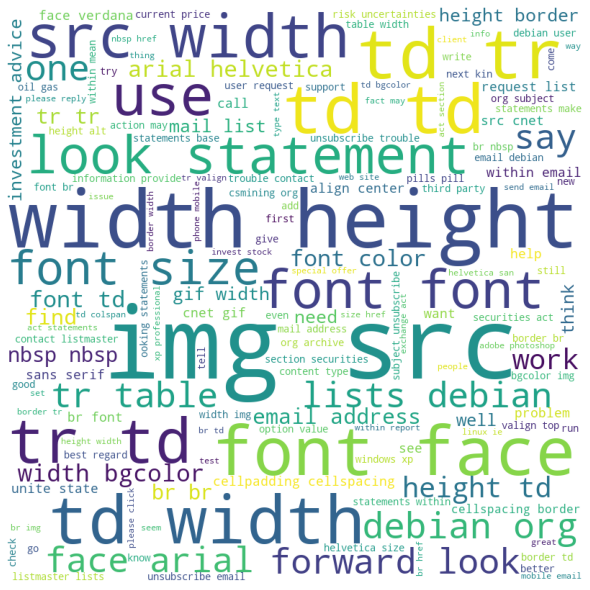

In [ ]:
email_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in spam_data.text:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    email_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(email_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()